# Лабораторная работа №5

Провести моделирование уравнения параболического типа.

## Вариант №11

Имеется бесконечная (периодическое замыкание вдоль $y$) композитная пластина толщины $H$. Основной материал пластины (матрица) имеет теплоемкость $c_0$, дополнительный материал (наполнитель) в форме небольших гранул имеет очень высокую теплоемкость $c_1 \gg c_0$. Плотность $\rho$ и теплопроводность $\kappa$ двух материалов совпадают. Левая граница пластины теплоизолирована, а правую границу пластины нагревают постоянным тепловым потоком, равномерно распределенным по границе. Смоделировать распространение тепла в пастине.


Выпишем постановку. Задачу будем решать в квадрате $[0, H] \times [0, H]$.

\begin{equation*}
\begin{cases}
    c\rho u_t = \text{div}(\kappa \nabla u), \ \ 0 < x < H,\ \ 0 < y < H \\
    u_x(0, y) = 0,\ \ u_x(H, y) = q \\
    u(x, y + H) = u(x, y) 
\end{cases}
\end{equation*}

Выпишем сеточный оператор (как и везде ранее будем использовать метод конечных объемов):

$ \displaystyle (Lu)_{i,j} = \Big([i > 1] \frac{u_{i,j} - u_{i-1, j}}{h_x^2} + [i < n_x] \frac{u_{i,j} - u_{i+1,j}}{h_x^2} + [j > 1] \frac{u_{i,j} - u_{i, j-1}}{h_y^2} + [j < n_y] \frac{u_{i,j} - u_{i, j+1}}{h_y^2} +$

$\displaystyle \ \ \ \ \ \ \ \ \ \ \ \ \ \ + [j = 1]\frac{u_{i, j} - u_{i, n_y}}{h_y^2} + [j = n_y]\frac{u_{i,j} - u_{i, 1}}{h_y^2} \Big)$

$\displaystyle (F)_{i,j} = 0 + [i = x_n]\frac{q}{h_x}$

Теперь выпишем схему Кранка-Николсон:

$$ P \frac{u^{(n+1)} - u^{(n)}}{\tau} + (1 - \nu)Lu^{(n)} + \nu Lu^{(n+1)} = F(t^{(n)} + \nu \tau), \ \ \nu \in [0, 1]$$

$ P$ — диагональная матрица коэффициентов $c\rho$ в ячейках. Так как по условию задачи вкрапления гранул мелкие, и $c_1 \gg c_0$, в некоторых отдельных ячейках значение будет просто $c_1$. Для заполнения будем генерировать случайную матрицу.

In [101]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse as sp
from scipy.sparse import linalg as LA
from IPython.display import clear_output
%matplotlib inline

In [102]:
H = 10
c_0 = 130 # как у свинца
c_1 = 1020 # как у магния
rho = 11000 # взял чуть меньше чем у свинца 
kappa = 50 # взял чуть больше чем у свинца
q = -100000000000000000 # плотность потока, взял произвольной
nu = 0.5

def RHS(X, Y, h_x, h_y):
    res = np.zeros_like(X, dtype=float)
    res[0, :] -= q / h_x # добивил сток для эксперимента
    res[-1,:] += q / h_x
    return res

In [103]:
def getL_csr(n_x, n_y, h_x, h_y):
    # двумерный массив элементы которого равны  индексу ячейки
    k = np.arange(n_x * n_y, dtype=int).reshape((n_x, n_y)) 

    I, J = np.meshgrid(np.arange(n_x), np.arange(n_y))
    I, J = I.flatten(), J.flatten()

    iC = k[I, J].flatten() # есть соседи снизу и сверху
    iB = k[I, (J - 1) % n_y].flatten() # соседи снизу
    iT = k[I, (J + 1) % n_y].flatten() # соседи сверху

    iHR = k[:-1, :].flatten() # есть сосед справа
    iR  = k[1: , :].flatten() # сосед справа

    iHL = k[1:  , :].flatten() # есть сосед слева
    iL  = k[:-1 , :].flatten() # сосед слева

    R1, C1, V1 = iC, iC, np.full(iC.size, +2.0/h_y**2)
    R2, C2, V2 = iC, iB, np.full(iC.size, -1.0/h_y**2)
    R3, C3, V3 = iC, iT, np.full(iC.size, -1.0/h_y**2)

    R4, C4, V4 = iHL, iHL, np.full(iHR.size, +1.0/h_x**2)
    R5, C5, V5 = iHL, iL,  np.full(iHL.size, -1.0/h_x**2)

    R6, C6, V6 = iHR, iHR, np.full(iHR.size, +1.0/h_x**2)
    R7, C7, V7 = iHR, iR,  np.full(iHR.size, -1.0/h_x**2)

    row = np.concatenate((R1, R2, R3, R4, R5, R6, R7))
    col = np.concatenate((C1, C2, C3, C4, C5, C6, C7))
    val = np.concatenate((V1, V2, V3, V4, V5, V6, V7))

    return sp.csr_matrix((val, (row, col)))

In [104]:
h_0 = 0.1
tau = 2 * h_0
l_x, l_y = 1, np.pi
n_x, n_y = int(np.round(H / h_0)), int(np.round(H / h_0))
h_x, h_y = H / n_x, H / n_y
x = np.linspace(h_x / 2, H - h_x / 2, n_x)
y = np.linspace(h_y / 2, H - h_y / 2, n_y)
X, Y = np.meshgrid(x, y, indexing='ij')

L = getL_csr(n_x, n_y, h_x, h_y)
F = RHS(X, Y, h_x, h_y).flatten()

Тут воспользуемся магией, и сгенерируем случайную матрицу для заполнения матрицы $P$:

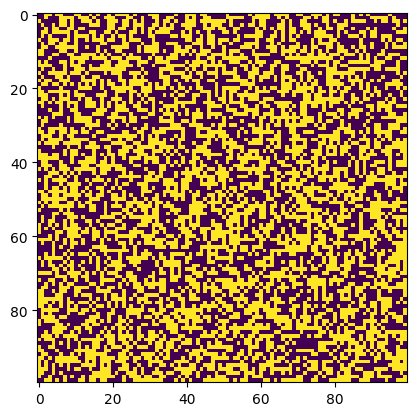

In [105]:
np.random.seed(11)

P = np.full((n_x, n_y), c_0 * rho)
P[np.random.choice([True, False], size=(n_x, n_y))] = c_1 * rho

plt.imshow(P.T)
plt.show()

Вернемся к численной схеме. Получим систему линейных уравнений:

$$ A = E + \tau \nu P^{-1} L, \ \ B = E - \tau (1-\nu)P^{-1} L, \ \ C = \tau P^{-1}F $$

$$ Au^{(n+1)} = Bu^{(n)} + C$$

Тут пользуемся очень удобным фактом, что F у нас в задаче не зависит от времени.

In [106]:
P_inv = sp.diags(1 / P.ravel(), format='csr')
A = sp.eye(n_x * n_y, format='csr') + tau * nu * P_inv @ L
B = sp.eye(n_x * n_y, format='csr') - tau * (1 - nu) * P_inv @ L
C = tau * P_inv @ F

В ячейке ниже будет проигрываться анимация, ее придется запустить.

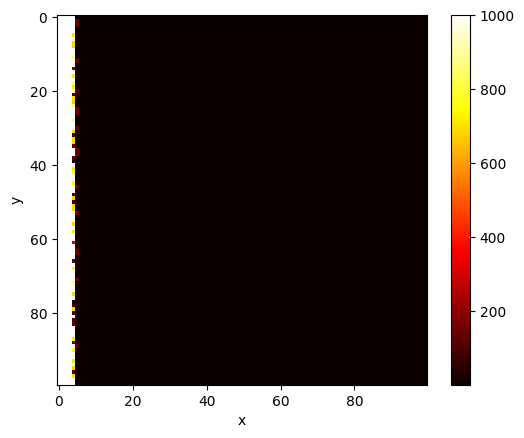

In [107]:
t_end = 300
u = np.ones(n_x * n_y) # положим начальную температуру константой
drawing_pause = 5
vmin = 1
vmax = 1000

for i in range(int(t_end / tau)):
    u, _ = LA.cg(A, B @ u + C, x0=u)
    if i % drawing_pause == 0:
        clear_output(True)
        plt.imshow(u.reshape(n_x, n_y).T, cmap='hot', vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

Гранулы ожидаемо прогреваются медленнее, чем остальная часть материала.